In [67]:
import numpy as np
import scipy
import csv
import matplotlib.pyplot as plt
from py3gpp import *

In [74]:
input_file = '/home/chatchamon/workarea/IQ_constellation/iq_python/input/IQDataFile_SPEEDTEST_10MS.csv'
# input_file = '/home/chatchamon/workarea/IQ_constellation/iq_python/input/IQDataFile_SPOTIFY2.csv'
# input_file = '/home/chatchamon/workarea/IQ_constellation/iq_python/input/IQDataFile_SPOTIFY.csv'
# input_file = '/home/chatchamon/workarea/IQ_constellation/iq_python/input/IQDataFile_SPEEDTEST.csv'

with open(input_file, 'r') as f:
    reader = csv.reader(f)
    for _ in range(19):
        next(reader)

    iq_val = []
    for row in reader:
        i_val = float(row[0])
        q_val = float(row[1])
        iq_val.append(complex(i_val,q_val))     # I+jQ

    # waveform_csv = np.array(iq_val[:230401])    # 10 ms
    waveform_csv = np.array(iq_val)

print('len_waveform_csv', len(waveform_csv), 'waveform_csv', waveform_csv)

len_waveform_csv 230401 waveform_csv [-0.00123117-0.00102036j  0.00109794-0.00055222j  0.00108245-0.00025547j
 ... -0.00217325+0.00065244j -0.00204915-0.00105801j
 -0.00108961-0.00154664j]


In [69]:
# downsampling, low pass filter
dec_factor = 8
waveform = scipy.signal.decimate(waveform_csv, dec_factor, ftype='fir')
# print("waveform after decimate:",waveform[:5])

# scale up max amplitude to 1
waveform /= max(waveform.real.max(), waveform.imag.max())
# print("waveform scale max amplitude to 1:",waveform[:5])
print('len_waveform', len(waveform), 'waveform', waveform)

sampleRate = 23.04e6
sampleRateDS = sampleRate // dec_factor     # floor devision, sampleRate down sample  

len_waveform 57601 waveform [ 0.01408304-0.01576645j  0.01269162-0.00973997j  0.00545108+0.00796199j
 ...  0.00232417-0.00360491j -0.00185765-0.00225724j
  0.02137476-0.00337091j]


In [70]:
# add SNR to the waveform
# SC polar decoder can decode this when repeated bits in nrRateMatchPolar() are used
np.random.seed(69)
noise = ((np.random.rand(waveform.shape[0]) - 0.5) + 1j*(np.random.rand(waveform.shape[0]) - 0.5)) * 0.8
SNR = 10*np.log10((np.linalg.norm(waveform) / np.linalg.norm(noise)))
waveform += noise
print(f'SNR = {SNR} dB')

SNR = -5.496771442202389 dB


In [71]:
nrbSSB = 20
scsSSB = 30
searchBW = 6*scsSSB

# shift by half scs step
fshifts = np.arange(-searchBW, searchBW+scsSSB, scsSSB)*1e3/2
print('len_fshifts', len(fshifts), 'fshifts:', fshifts)

t = np.arange(len(waveform))/sampleRateDS
# print('len_t', len(t),'t',t)

len_fshifts 13 fshifts: [-90000. -75000. -60000. -45000. -30000. -15000.      0.  15000.  30000.
  45000.  60000.  75000.  90000.]


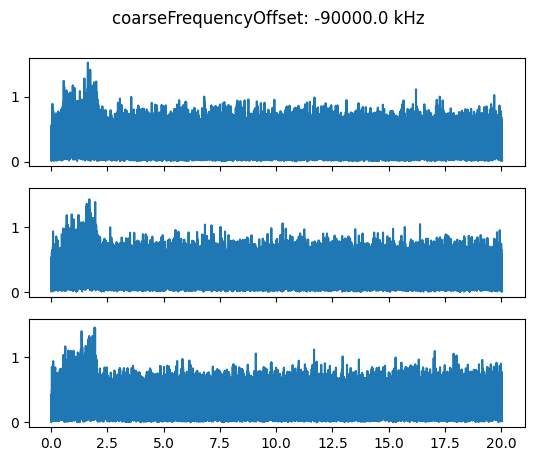

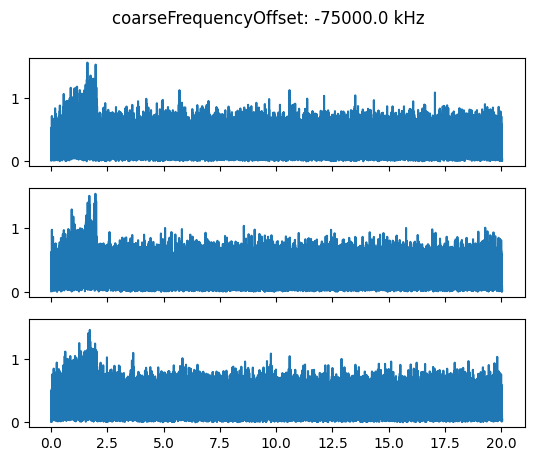

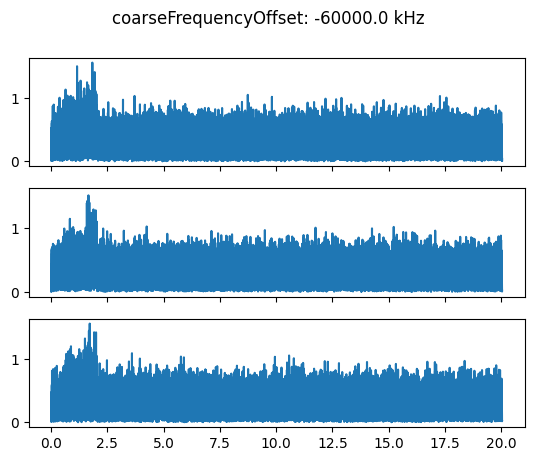

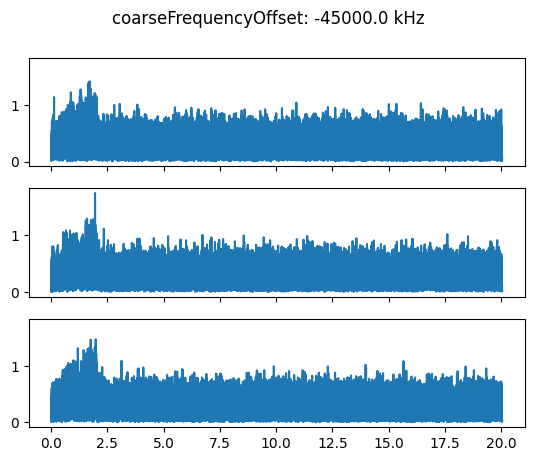

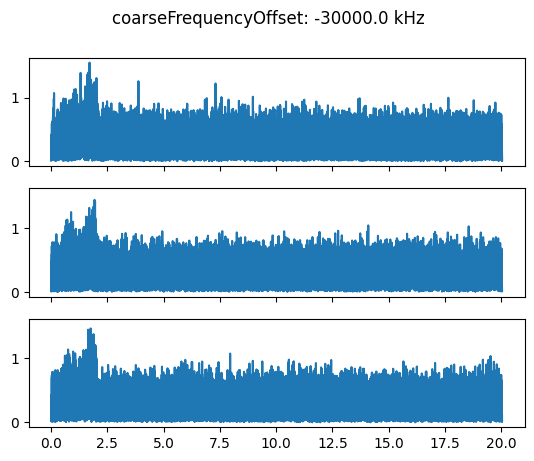

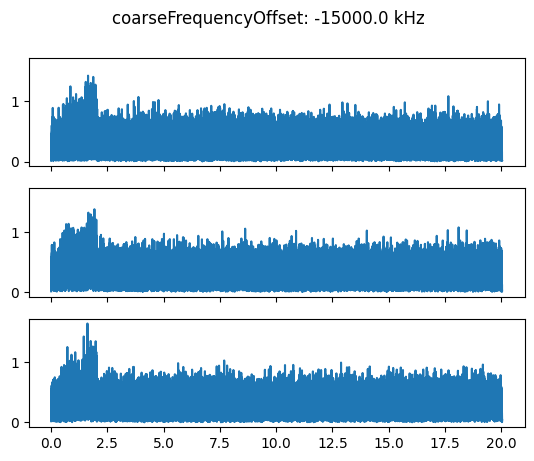

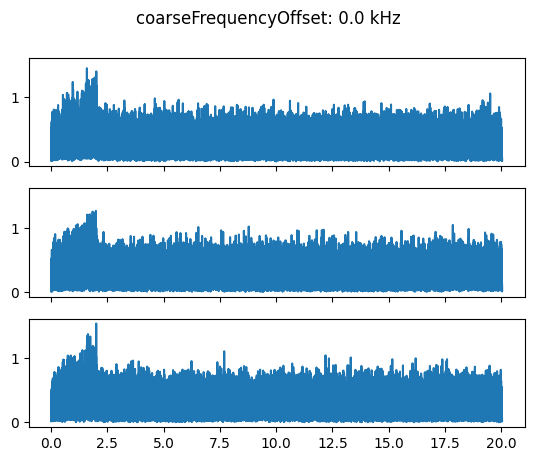

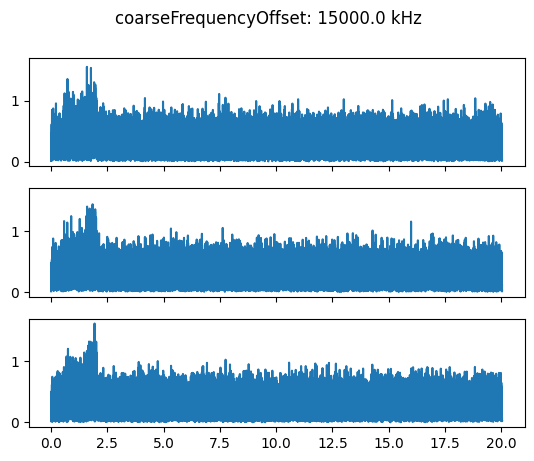

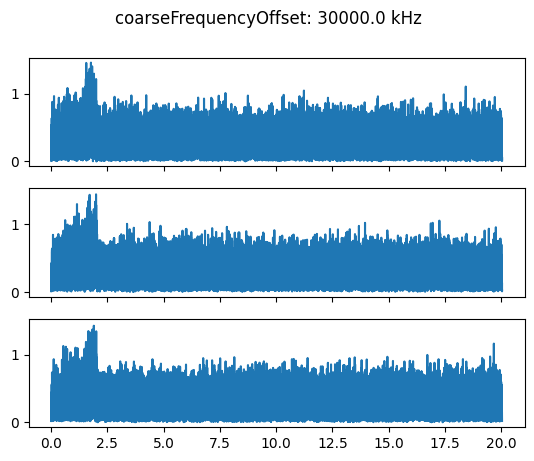

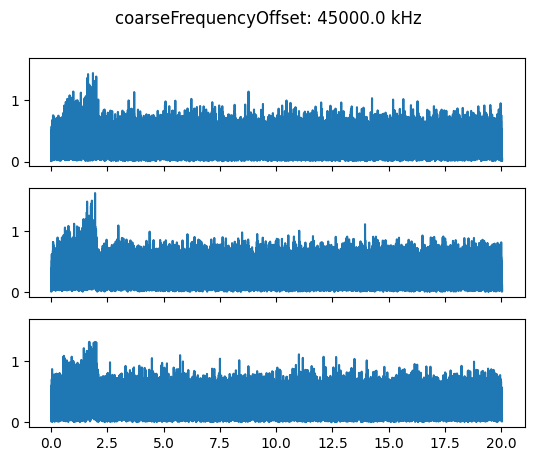

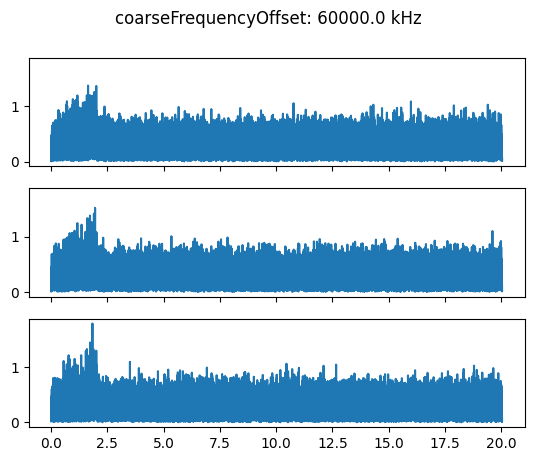

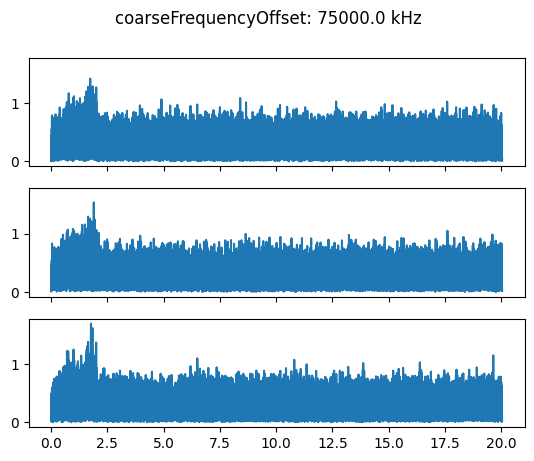

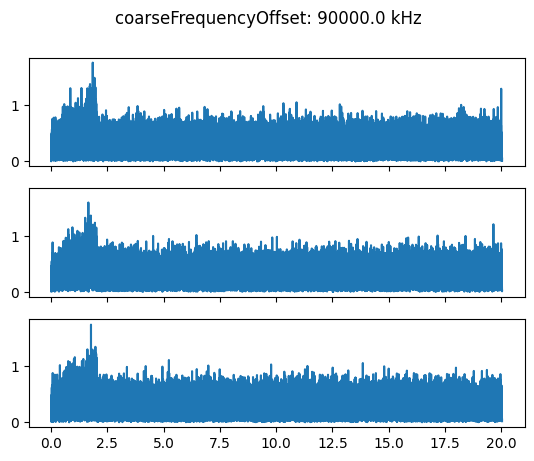

In [72]:
# it will always be the same, no need to stay in the loop
carrier = nrCarrierConfig(NSizeGrid = nrbSSB, SubcarrierSpacing = scsSSB)
info = nrOFDMInfo(carrier)
Nfft = info['Nfft']         # scs = 30kHz, Nfft = 512

kPSS = np.arange(56, 183)

peak_value = np.zeros((len(fshifts),3))
peak_index = np.zeros((len(fshifts),3), 'int')

# loop on fshifts
for fshifts_index in np.arange(len(fshifts), dtype='int'):
    coarseFrequencyOffset = fshifts[fshifts_index]
    # print('coarseFrequencyOffset:', coarseFrequencyOffset)

    # shift frequency by coarseFrequencyOffset
    rxWaveformFrquencyCorrect = waveform*np.exp(-1j*2*np.pi*coarseFrequencyOffset*t)
    nSlot = 0
    T = len(rxWaveformFrquencyCorrect)

    slotGrid = nrResourceGrid(carrier)
    slotGrid = slotGrid[:,1]

    # loop on NID2
    fig, axs = plt.subplots(3, 1, facecolor='w', sharex=True, sharey=True)
    fig.suptitle(f"coarseFrequencyOffset: {coarseFrequencyOffset} kHz")
    for current_NID2 in np.arange(3, dtype='int'):
        # current_NID2 = 1
        slotGrid[kPSS] = nrPSS(current_NID2)        # at slot index KPSS assign value nrPSS(current_NID2)
        # generate refWaveform by modulate signal on carrier and slotGrid with assigned nrPSS
        [refWaveform, info] = nrOFDMModulate(carrier, slotGrid, scsSSB, nSlot, Nfft, SampleRate=sampleRateDS)
        refWaveform = refWaveform[info['CyclicPrefixLengths'][0]:]; # remove CP

        # cross correlate waveform with refWaveform
        temp = scipy.signal.correlate(rxWaveformFrquencyCorrect, refWaveform)
        t_corr = np.arange(temp.shape[0])/sampleRateDS*1e3

        # record magnitude 
        peak_index[fshifts_index, current_NID2] = np.argmax(np.abs(temp))
        peak_value[fshifts_index, current_NID2] = np.abs(temp[peak_index[fshifts_index, current_NID2]])

        # plot result, number of display figure = len(fshifts)s
        axs[current_NID2].plot(t_corr, np.abs(temp))

# print(peak_index)
# print(peak_value)

In [73]:
max_corr = np.max(peak_value)
select_row = np.floor(np.argmax(peak_value) // 3)   
freqOffset = fshifts[select_row]    
NID2 = np.argmax(peak_value[select_row,:])

print("max_corr", max_corr)
print("freqOffset", freqOffset, "NID2", NID2)

peak_value

max_corr 1.7887072970379168
freqOffset 60000.0 NID2 2


array([[1.52239638, 1.42765435, 1.45980204],
       [1.55628562, 1.5449127 , 1.45546405],
       [1.55306548, 1.51717137, 1.55199522],
       [1.41888371, 1.74849367, 1.46943822],
       [1.54766586, 1.44132466, 1.47031096],
       [1.42660732, 1.37460876, 1.64312919],
       [1.45443967, 1.26412679, 1.54210534],
       [1.5535827 , 1.43894981, 1.62271768],
       [1.45707143, 1.43841098, 1.42453643],
       [1.44937401, 1.62078172, 1.32073116],
       [1.37341084, 1.52096348, 1.7887073 ],
       [1.41903594, 1.53248831, 1.69349183],
       [1.75779448, 1.59009806, 1.73765837]])